# Speed control in biological sequence-generating network

Conductance-based LIF network. Single-neuron voltage dynamics:

$$C_m \frac{dV}{dt} = g_l[E_l - V(t)] + g_e(t)[E_e - V(t)] + g_i(t)[E_i - V(t)] + I_{ext}(t)$$

The time-varying conductances $g_e(t)$ and $g_i(t)$ are exponentially filtered sums of spike trains from upstream neurons $j$, with time constants $\tau_e$ and $\tau_i$ and weighted by $W_e^{ij}$ and $W_i^{ij}$, respectively (convention: weight to $i$ from $j$):

$$\tau_e\frac{dg^i_e}{dt} = -g^i_e + \sum_j W_e^{ij} \sum_{t_k^j} \delta(t - t_k^j)$$

$$\tau_i\frac{dg^i_i}{dt} = -g^i_i + \sum_j W_i^{ij} \sum_{t_k^j} \delta(t - t_k^j)$$

where $t_k^j$ are the spike times in the $j$-th neuron.


## Next steps

In [29]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os
from colour import Color

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG, join_w
from utils.general import *

cc = np.concatenate

# PARAMS
## NEURON AND NETWORK MODEL
M = Generic(
    # Excitatory membrane
    C_M_E=1e-6,  # membrane capacitance
    G_L_E=.1e-3,  # membrane leak conductance (T_M (s) = C_M (F/cm^2) / G_L (S/cm^2))
    E_L_E=-.06,  # membrane leak potential (V)
    V_TH_E=-.05,  # membrane spike threshold (V)
    T_R_E=2e-3,  # refractory period (s)
    
    # Inhibitory membrane
    #C_M_I=1e-6,
    #G_L_E=.1e-3, 
    #E_L_I=-.06,
    #V_TH_E=-.05,
    #T_R_I=.002,
    
    # syn rev potentials and decay times
    E_E=0, E_I=-.08, E_A=-0.1, T_E=.002, T_I=.002, T_A=0.01,

    # NTWK ARCHITECTURE
    N_L=40,  # num chain links
    N_L_E=30,  # num E nrns per chain link
    N_P_I = 300, # num nrns in inhibitory pool
    W_E_E_R=0.005e-3,  # E-E recurrent cxns w/in chain link
    W_E_E_F=0.01e-3,  # E-E feed-forward from one link to next
    W_U_E_I=0.1e-3,  # I->E input weights
    W_U_I=0.8e-3,
    W_A=0, # adaptation weight for all neurons
    
    # OTHER INPUTS
    SGM_N=.5e-9,  # noise level (A*sqrt(s))
    I_EXT_B=0,  # additional baseline current input
)

def set_dynamic_vars(m):
    m.N_E = m.N_L * m.N_L_E
    m.N_N = m.N_E + m.N_P_I

set_dynamic_vars(M)

## SMLN
S = Generic(RNG_SEED=0, DT=.0005)

print('T_M_E =', 1000*M.C_M_E/M.G_L_E, 'ms')  # E cell membrane time constant (C_m/g_m)

T_M_E = 10.0 ms


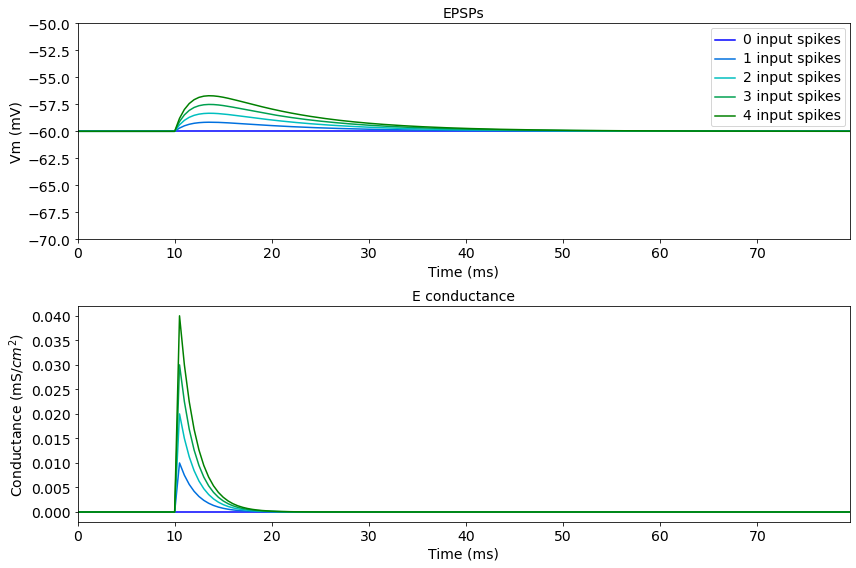

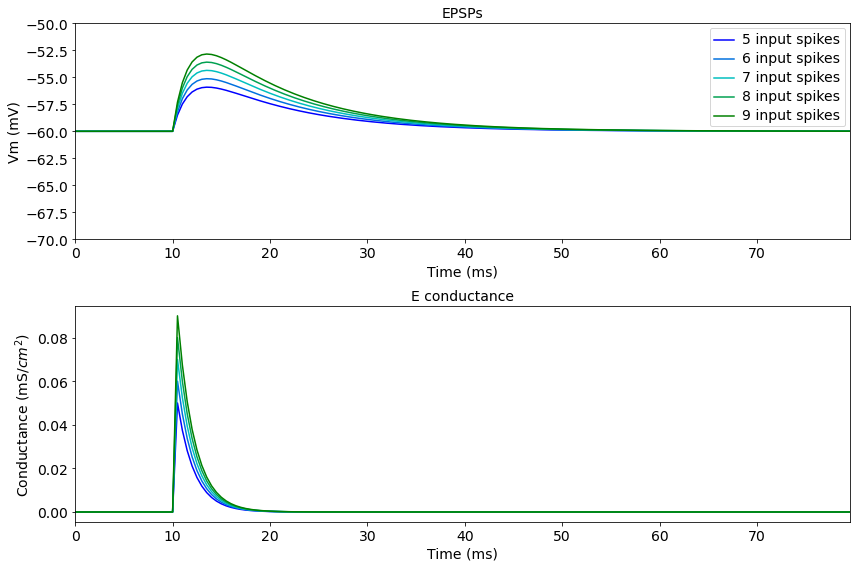

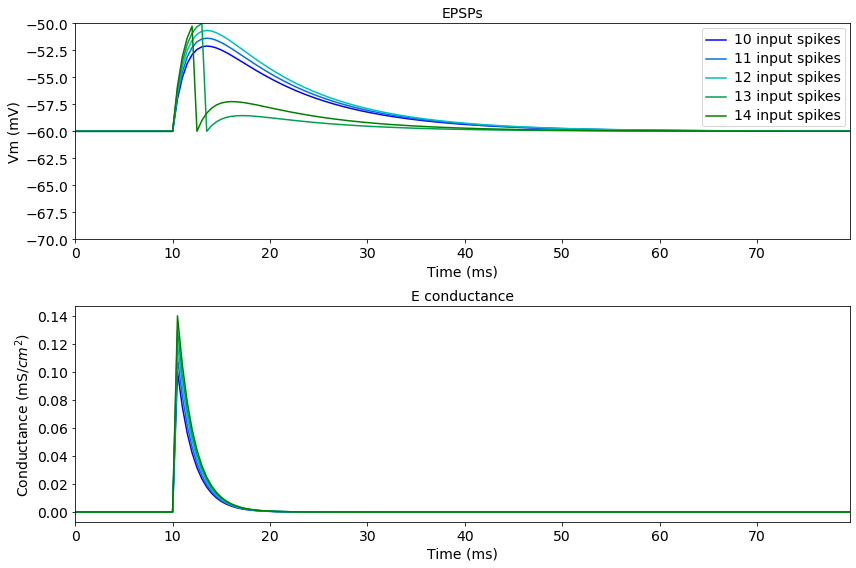

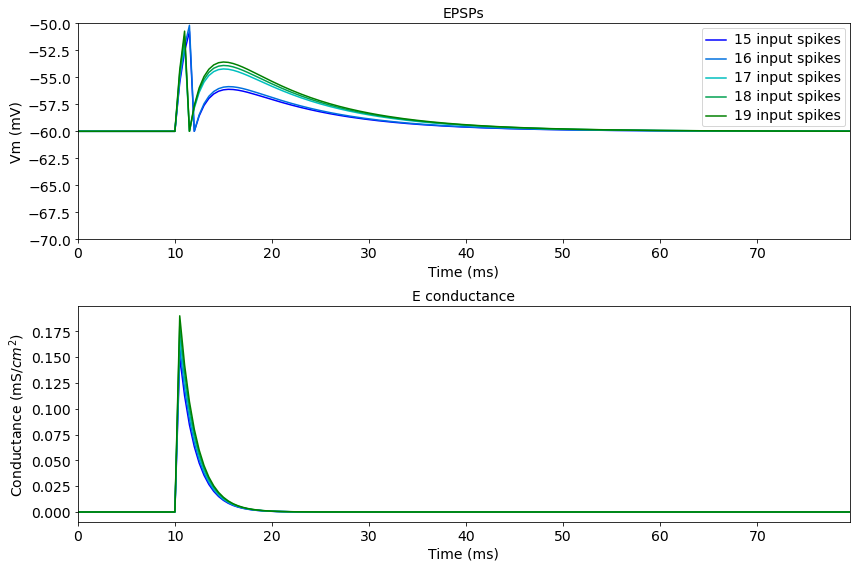

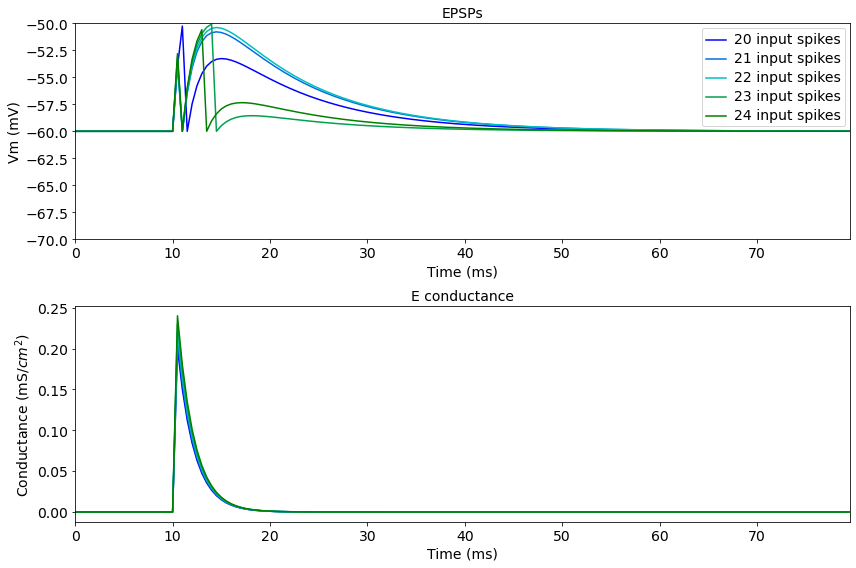

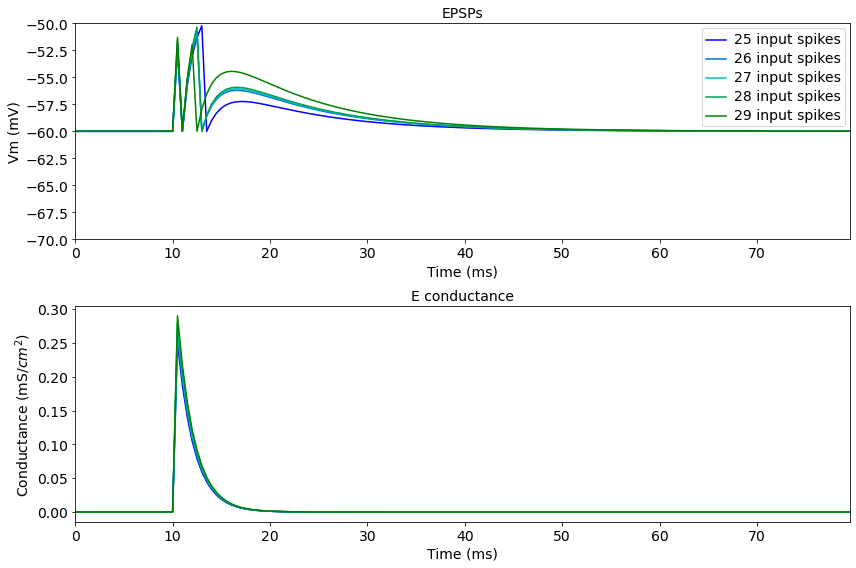

In [40]:
np.random.seed(0)
# EPSP size vs E weight
t = np.arange(0, .08, S.DT)

MAX_INPUTS = M.N_L_E
BATCH_SIZE = 5

for n_input_cap in np.arange(BATCH_SIZE, MAX_INPUTS + 1, BATCH_SIZE):
    rsps_e = []
    
    for n_inputs in np.arange(n_input_cap - BATCH_SIZE, n_input_cap):
        w_u_e_i = 0

        ntwk = LIFNtwkG(
            c_m=M.C_M_E,
            g_l=M.G_L_E,
            e_l=M.E_L_E,
            v_th=M.V_TH_E,
            v_r=M.E_L_E,
            t_r=np.inf,
            e_s={'E': M.E_E, 'I': M.E_I},
            t_s={'E': M.T_E, 'I': M.T_I},
            w_r={'E': np.zeros([1]*2), 'I': np.zeros([1]*2)},
            w_u={
                'E': np.concatenate([M.W_E_E_F * np.ones(MAX_INPUTS), np.zeros(1)], axis=0),
                'I': np.concatenate([np.zeros(MAX_INPUTS), w_u_e_i * np.ones(1)], axis=0)
                }
        )

        spks_u = np.zeros((len(t), MAX_INPUTS + 1), dtype=int)
        for i in range(n_inputs):
            spks_u[int(round(.01/S.DT)), i] = 1
        rsp = ntwk.run(
            dt=S.DT,
            clamp=Generic(v={0: np.array([M.E_L_E])}, spk={}),
            i_ext=np.zeros(len(t)),
            spks_u=spks_u)

        rsps_e.append(copy(rsp))


    # IPSP size vs I weight
    rsps_i = []

    for w_u_e_i in np.arange(10) * 0.01e-3:
        w_u_e_e = 0

        ntwk = LIFNtwkG(
            c_m=M.C_M_E,
            g_l=M.G_L_E,
            e_l=M.E_L_E,
            v_th=M.V_TH_E,
            v_r=M.E_L_E,
            t_r=np.inf,
            e_s={'E': M.E_E, 'I': M.E_I},
            t_s={'E': M.T_E, 'I': M.T_E},
            w_r={'E': np.zeros([1]*2), 'I': np.zeros([1]*2)},
            w_u={
                'E': np.concatenate([M.W_E_E_F * np.ones(MAX_INPUTS), np.zeros(1)], axis=0),
                'I': np.concatenate([np.zeros(MAX_INPUTS), w_u_e_i * np.ones(1)], axis=0)
                }
        )

        spks_u = np.zeros((len(t), MAX_INPUTS + 1), dtype=int)
        spks_u[int(round(.01/S.DT)), -1] = 1
        rsp = ntwk.run(
            dt=S.DT,
            clamp=Generic(v={0: np.array([M.E_L_E])}, spk={}),
            i_ext=np.zeros(len(t)),
            spks_u=spks_u)

        rsps_i.append(copy(rsp))


    # plot
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), tight_layout=True)
    
    colors_e = list(Color('blue').range_to(Color('green'), len(rsps_e)))
    colors_i = list(Color('blue').range_to(Color('green'), len(rsps_i)))
    
    for idx, rsp_e in enumerate(rsps_e):
        axs[0].plot(1000*t, 1000*rsp_e.vs[:, 0], color=colors_e[idx].hex, label=f'{n_input_cap - 5 + idx} input spikes')
        axs[1].plot(1000*t, 1000*rsp_e.gs['E'][:, 0], color=colors_e[idx].hex)
#     for idx, rsp_i in enumerate(rsps_i):
#         axs[0, 1].plot(1000*t, 1000*rsp_i.vs[:, 0], color=colors_i[idx].hex)
#         axs[1, 1].plot(1000*t, 1000*rsp_i.gs['I'][:, 0], color=colors_i[idx].hex)

    axs[0].set_xlim(1000*t.min(), 1000*t.max())
    axs[0].set_ylim(-70, -50)
    axs[0].set_xlabel('Time (ms)')
    axs[0].set_ylabel('Vm (mV)')
    axs[0].legend()

    axs[1].set_xlim(1000*t.min(), 1000*t.max())
    axs[1].set_xlabel('Time (ms)')
    axs[1].set_ylabel('Conductance (mS/$cm^2$)')

    axs[0].set_title('EPSPs')
#     axs[0, 1].set_title('IPSPs')

    axs[1].set_title('E conductance')
#     axs[1, 1].set_title('I conductance')

    for ax in axs.flatten():
        set_font_size(ax, 14)

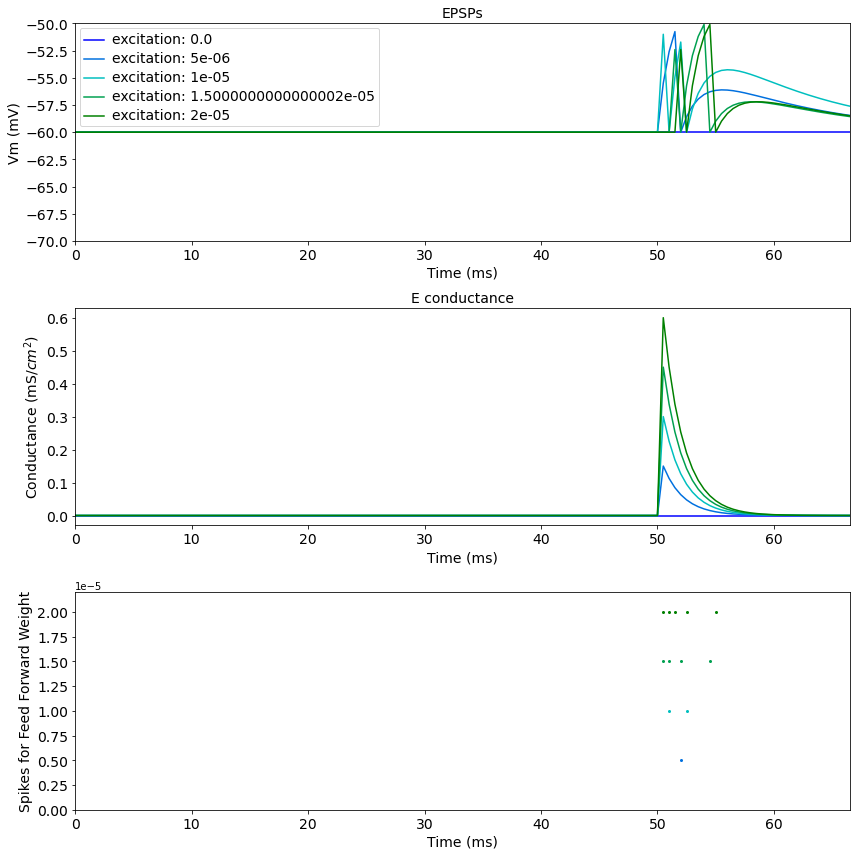

In [ ]:
np.random.seed(0)
# EPSP size vs E weight
t = np.arange(0, .2, S.DT)

MAX_INPUTS = M.N_L_E
N_STEPS = 5
W_E_E_F_MAX = 2 * M.W_E_E_F
fq_spk_u_i = 800
W_U_E_I_MAX = 3e-5

for w_u_e_i in np.linspace(0, W_U_E_I_MAX, 3):
    rsps_e = []
    
    for w_u_e_e in np.linspace(0, W_E_E_F_MAX, N_STEPS):

        ntwk = LIFNtwkG(
            c_m=M.C_M_E,
            g_l=M.G_L_E,
            e_l=M.E_L_E,
            v_th=M.V_TH_E,
            v_r=M.E_L_E,
            t_r=np.inf,
            e_s={'E': M.E_E, 'I': M.E_I},
            t_s={'E': M.T_E, 'I': M.T_I},
            w_r={'E': np.zeros([1]*2), 'I': np.zeros([1]*2)},
            w_u={
                'E': np.concatenate([w_u_e_e * np.ones(MAX_INPUTS), np.zeros(1)], axis=0),
                'I': np.concatenate([np.zeros(MAX_INPUTS), w_u_e_i * np.ones(1)], axis=0)
                }
        )

        spks_u = np.zeros((len(t), MAX_INPUTS + 1), dtype=int)
        for i in range(MAX_INPUTS):
            spks_u[int(round(.05/S.DT)), i] = 1
        spks_u[:, -1] = np.random.poisson(fq_spk_u_i * S.DT, len(t))
        rsp = ntwk.run(
            dt=S.DT,
            clamp=Generic(v={0: np.array([M.E_L_E])}, spk={}),
            i_ext=np.zeros(len(t)),
            spks_u=spks_u)

        rsps_e.append(copy(rsp))


    # plot
    fig, axs = plt.subplots(3, 1, figsize=(12, 12), tight_layout=True)
    colors_e = list(Color('blue').range_to(Color('green'), len(rsps_e)))

    for idx, rsp_e in enumerate(rsps_e):
        w_u_e_e = W_E_E_F_MAX * (idx) / (N_STEPS - 1)
        axs[0].plot(1000*t, 1000*rsp_e.vs[:, 0], color=colors_e[idx].hex, label=f'excitation: {W_E_E_F_MAX * (idx) / (N_STEPS - 1)}')
        axs[1].plot(1000*t, 1000*rsp_e.gs['E'][:, 0], color=colors_e[idx].hex)
        axs[2].scatter(1000 * rsp_e.spks_t, w_u_e_e * np.ones(rsp_e.spks_t.shape), color=colors_e[idx].hex, s=4)

    axs[0].set_xlim(1000*t.min(), 1000*t.max() / 3)
    axs[0].set_ylim(-70, -50)
    axs[0].set_xlabel('Time (ms)')
    axs[0].set_ylabel('Vm (mV)')
    axs[0].legend()

    axs[1].set_xlim(1000*t.min(), 1000*t.max() / 3)
    axs[1].set_xlabel('Time (ms)')
    axs[1].set_ylabel('Conductance (mS/$cm^2$)')
    
    axs[2].set_xlim(1000*t.min(), 1000*t.max() / 3)
    axs[2].set_ylim(0, W_E_E_F_MAX * 1.1)
    axs[2].set_xlabel('Time (ms)')
    axs[2].set_ylabel('Spikes for Feed Forward Weight')

    axs[0].set_title('EPSPs')

    axs[1].set_title('E conductance')

    for ax in axs.flatten():
        set_font_size(ax, 14)